In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

t_data = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

t_data = np.array(t_data)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], t_data.reshape(-1,1)), axis=1)

xExp = xExp.astype(float)


In [3]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)
tExpTrunc = xExpTruncNormal[:,-1]

In [4]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=30)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

## Part1 (0-0.24 sec)

In [5]:
from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
quad_interp_p2 = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
xTrain = quad_interp_p2(tTrain) 

In [6]:
clear true_y 

In [7]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.float)
t = torch.from_numpy(tTrain).to(dtype=torch.float)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.float)

In [10]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

## Utility functions for visualization of results 
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, frameon=False)
    plt.show(block=False)

def visualize(true_y, pred_y, odefunc, itr):

    if args.viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-', label = 'True System')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--', label = 'Neural ODE')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001)


## Construct a neural network to approximate the dynamics of an ODE
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
func = ODEFunc().to(device)
    
def combined_system(t, y):
    dt_dt = 1;
    dt_dt = torch.tensor([dt_dt])
    output_tensor = func(t, y)  # Using ODEFunc to get dx2/dt, dx3/dt, dx4/dt
    return torch.cat([output_tensor,dt_dt], dim=0)

In [12]:
ii = 0
## Setting up the optimizer
optimizer = optim.RMSprop(func.parameters(), lr=0.001)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_y_toCaclLoss= torch.stack(solutions).unsqueeze(0)
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_y_toCaclLoss - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_y = pred_y.unsqueeze(1)  
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

Iter 0001 | Total Loss 0.365340
Iter 0020 | Total Loss 0.291641
Iter 0040 | Total Loss 0.279154
Iter 0060 | Total Loss 0.280967
Iter 0080 | Total Loss 0.279658
Iter 0100 | Total Loss 0.330878
Iter 0120 | Total Loss 0.411161
Iter 0140 | Total Loss 0.483164
Iter 0160 | Total Loss 0.521877
Iter 0180 | Total Loss 0.584121
Iter 0200 | Total Loss 0.518889
Iter 0220 | Total Loss 0.483716
Iter 0240 | Total Loss 0.484668
Iter 0260 | Total Loss 0.426552
Iter 0280 | Total Loss 0.429620
Iter 0300 | Total Loss 0.391338
Iter 0320 | Total Loss 0.408512
Iter 0340 | Total Loss 0.417660
Iter 0360 | Total Loss 0.397814
Iter 0380 | Total Loss 0.414656
Iter 0400 | Total Loss 0.380672
Iter 0420 | Total Loss 0.436699
Iter 0440 | Total Loss 0.398035
Iter 0460 | Total Loss 0.381854
Iter 0480 | Total Loss 0.354410
Iter 0500 | Total Loss 0.382275
Iter 0520 | Total Loss 0.369868
Iter 0540 | Total Loss 0.346259
Iter 0560 | Total Loss 0.370502
Iter 0580 | Total Loss 0.323897
Iter 0600 | Total Loss 0.330256
Iter 062

KeyboardInterrupt: 

NameError: name 'temp_x_t_m_p2' is not defined

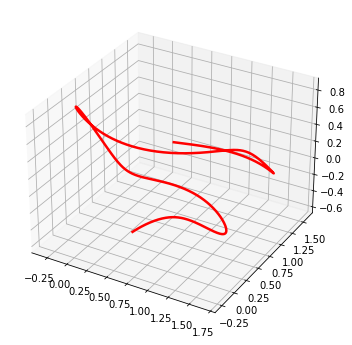

In [13]:
# Assuming ODEFunc is the name of your neural network class
model = func


model.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 0], predicted_states[:, 1], predicted_states[:, 2], "r", label="$Neural-ODE-model$", linewidth=2.5,alpha =1)
ax.plot(temp_x_t_m_p2[:, 0], temp_x_t_m_p2[:, 1], temp_x_t_m_p2[:, 2], "b", label="True value", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

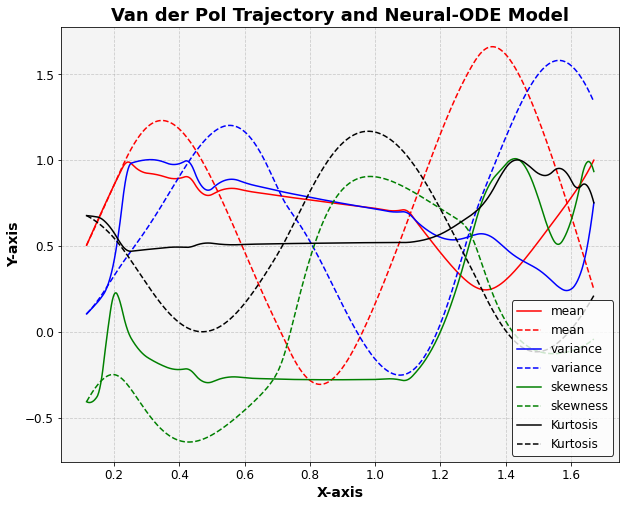

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrain[:,0], 'r',label='mean')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean')

plt.plot(tTrain,xTrain[:,1], 'b',label='variance')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance')

plt.plot(tTrain,xTrain[:,2], 'g',label='skewness')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness')

plt.plot(tTrain,xTrain[:,3], 'k',label='Kurtosis')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Van der Pol Trajectory and Neural-ODE Model", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('van_der_pol_plot.pdf', bbox_inches='tight')

# Show the plot
plt.show()


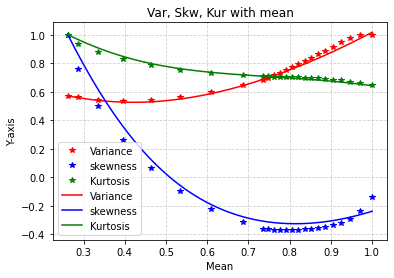

In [15]:
# Create a plot with different labels for each column
plt.plot(temp_m_t_p2, temp_x_t_m_p2[:, 1], 'r*',label='Variance')
plt.plot(temp_m_t_p2, temp_x_t_m_p2[:, 2], 'b*',label='skewness')
plt.plot(temp_m_t_p2, temp_x_t_m_p2[:, 3], 'g*',label='Kurtosis')

plt.plot(t, predicted_states[:, 1], 'r',label='Variance')
plt.plot(t, predicted_states[:, 2], 'b',label='skewness')
plt.plot(t, predicted_states[:, 3], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

In [49]:
optimizer = optim.RMSprop(func.parameters(), lr=0.00001)
for itr in range(3001, 4000):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1
 

Iter 3020 | Total Loss 0.206099
Iter 3040 | Total Loss 0.206067
Iter 3060 | Total Loss 0.206067
Iter 3080 | Total Loss 0.206076
Iter 3100 | Total Loss 0.206206
Iter 3120 | Total Loss 0.206211
Iter 3140 | Total Loss 0.206156
Iter 3160 | Total Loss 0.206139
Iter 3180 | Total Loss 0.206199
Iter 3200 | Total Loss 0.206249
Iter 3220 | Total Loss 0.206270
Iter 3240 | Total Loss 0.206252
Iter 3260 | Total Loss 0.206230
Iter 3280 | Total Loss 0.206246
Iter 3300 | Total Loss 0.206277
Iter 3320 | Total Loss 0.206277
Iter 3340 | Total Loss 0.206384
Iter 3360 | Total Loss 0.206315
Iter 3380 | Total Loss 0.206301
Iter 3400 | Total Loss 0.206353
Iter 3420 | Total Loss 0.206341
Iter 3440 | Total Loss 0.206503
Iter 3460 | Total Loss 0.206481
Iter 3480 | Total Loss 0.206531
Iter 3500 | Total Loss 0.206549
Iter 3520 | Total Loss 0.206572
Iter 3540 | Total Loss 0.206500
Iter 3560 | Total Loss 0.206388
Iter 3580 | Total Loss 0.206466
Iter 3600 | Total Loss 0.206349
Iter 3620 | Total Loss 0.206431
Iter 364

In [11]:
np.shape(batch_y0)

torch.Size([30, 1, 3])

In [10]:
batch_t

tensor([0.0482, 0.0485, 0.0487, 0.0489, 0.0492, 0.0494, 0.0496, 0.0499, 0.0501,
        0.0504, 0.0506, 0.0508, 0.0511, 0.0513, 0.0515, 0.0518, 0.0520, 0.0523,
        0.0525, 0.0527, 0.0530, 0.0532, 0.0535, 0.0537, 0.0539, 0.0542, 0.0544,
        0.0546, 0.0549, 0.0551])

In [26]:
max(x_train[:,0])

7.89066450745324

In [22]:
true_y0

tensor([[ 0.5713,  1.0000,  1.0000],
        [ 0.5710,  0.9920,  0.9975],
        [ 0.5707,  0.9841,  0.9951],
        ...,
        [ 0.9962, -0.1414,  0.6456],
        [ 0.9956, -0.1382,  0.6452],
        [ 0.9949, -0.1349,  0.6448]])

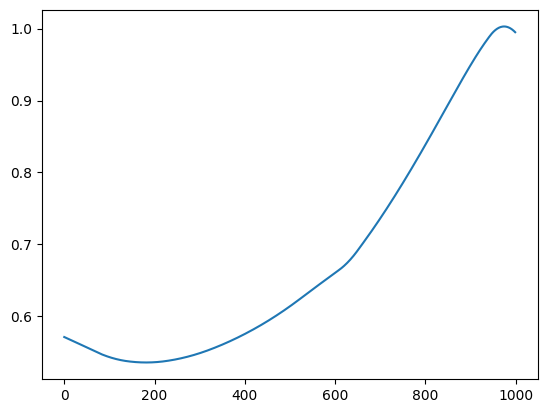

In [44]:
plt.plot(x_t_m_p2[:,0])

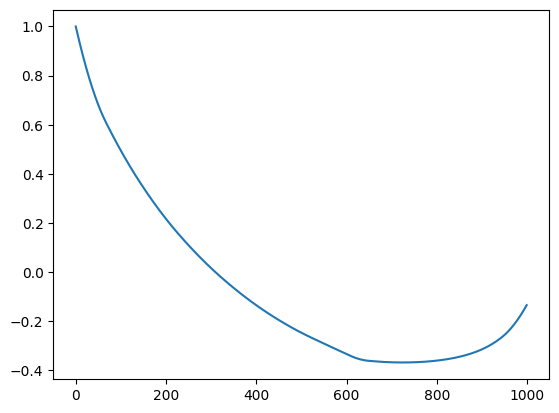

In [45]:
plt.plot(x_t_m_p2[:,1])

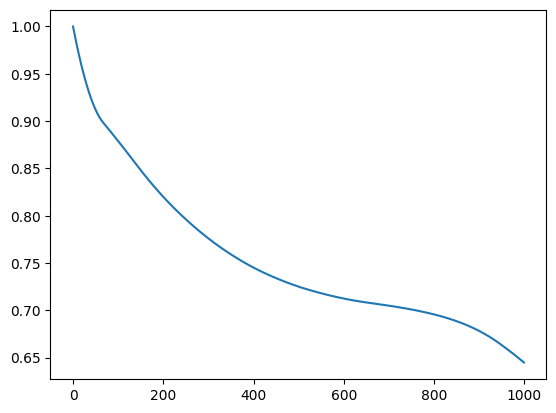

In [46]:
plt.plot(x_t_m_p2[:,2])

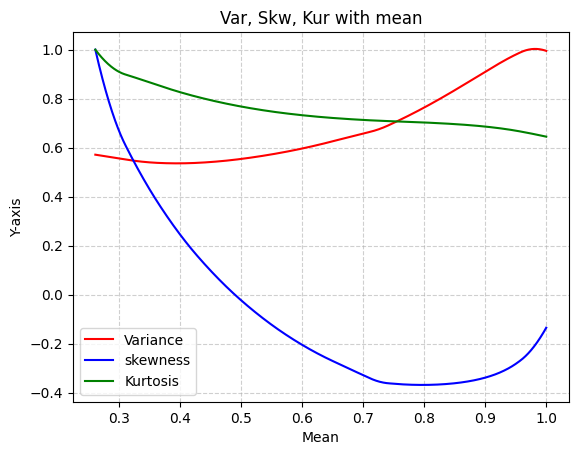

In [56]:
# Create a plot with different labels for each column

plt.plot(m_quad_p2, x_t_m_p2[:, 0], 'r',label='Variance')
plt.plot(m_quad_p2, x_t_m_p2[:, 1], 'b',label='skewness')
plt.plot(m_quad_p2, x_t_m_p2[:, 2], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

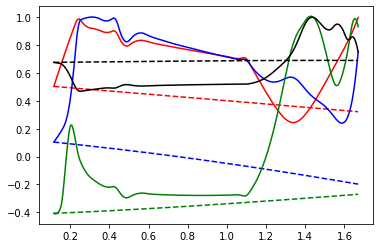